# Opera Package

#### Cargamos las librerias auxiliares

In [1]:
library(ggplot2)
library(zoo)
library(forecast)
library(tseries)
library(FitARMA)

Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'zoo' was built under R version 3.3.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'tseries' was built under R version 3.3.3"Warning message:
"package 'FitARMA' was built under R version 3.3.3"Loading required package: FitAR
Warning message:
"package 'FitAR' was built under R version 3.3.3"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.3.3"Loading required package: leaps
Warning message:
"package 'leaps' was built under R version 3.3.3"Loading required package: ltsa
Loading required package: bestglm
Warning message:
"package 'bestglm' was built under R version 3.3.3"
Attaching package: 'FitAR'

The following object is masked from 'package:forecast':

    BoxCox



#### Cargamos Opera

In [2]:
#install.packages('opera')
library(opera)

Warning message:
"package 'opera' was built under R version 3.3.3"

#### Cargamos los datos

In [3]:
datos <- read.csv('monthly-traffic-fatalities-in-on.csv')
accidentes <- ts(datos, start = c(1960, 1), frequency = 12)

#### Training y test

In [4]:
acc.train <- window(accidentes, start = c(1960,1), end = c(1973,12))
acc.test <- window(accidentes, start = c(1974,1))

#### Función genérica para plotting de test vs pred a través de ggplot2

In [5]:
combine <- function(test, pred) {
  require(ggplot2)
  p <- ggplot() +
    geom_line(aes(x = index(as.zoo(test)), y = coredata(as.zoo(test)), colour = 'Test')) +
    geom_line(aes(x = index(as.zoo(test)), y = pred, colour = 'Prediccion')) +
    scale_color_manual(name = 'Leyenda', values = c('Test' = 'black', 'Prediccion' = 'red'),
                       labels = c('Test','Prediccion'))
  p
}

#### Red neuronal

In [6]:
red <- nnetar(acc.train, repeats = 25, size = 20, decay = 9.5, p = 20, P = 4)
pred.red <- forecast(red, h = 12)
accuracy(pred.red, acc.test) # 13.2...

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.002991391,19.34309,15.19108,-2.903809,11.53244,0.8564541,0.1844513,NA
Test set,-5.963355912,14.82810,13.28108,-5.740246,10.15662,0.7487704,-0.4263985,0.4423592


<br>

#### SARIMA(1,0,0)(1,0,0)12

In [7]:
sarima <- auto.arima(acc.train, test = 'adf')
pred.sarima <- forecast(sarima, h = 12)
accuracy(pred.sarima, acc.test) # 14.86938

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,1.481911,20.89727,16.32299,-2.080903,13.43304,0.9202698,-0.0813211,NA
Test set,-8.013324,18.19253,14.86938,-8.041157,12.04800,0.8383172,-0.2694620,0.4505771


<br>

#### Damped HoltWinters Mutiplicativo

In [8]:
pred.hw <- hw(acc.train, h = 12, damped = TRUE, seasonal = 'multiplicative',
            initial = 'optimal')
accuracy(pred.hw, acc.test) # 15.04762

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,1.113903,16.03383,12.68223,-0.4267724,9.854084,0.7150085,0.08131717,NA
Test set,-13.063209,20.12153,15.04762,-10.5419375,11.866680,0.8483659,-0.33286407,0.5553684


<br>

#### Juntamos las predicciones

Don't know how to automatically pick scale for object of type yearmon. Defaulting to continuous.


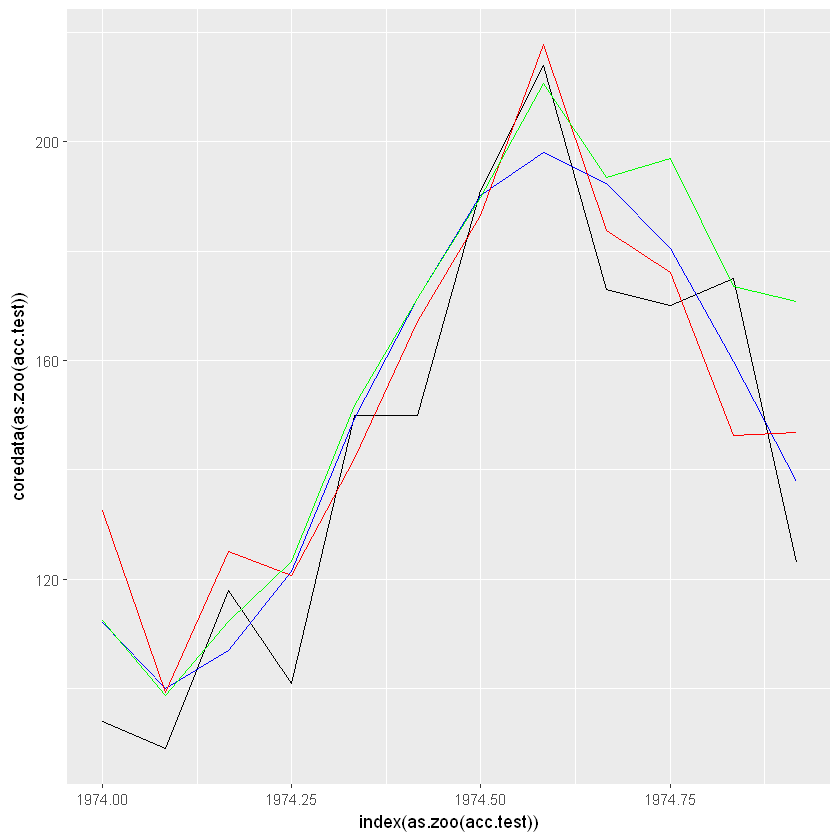

In [9]:
X <- cbind(red = pred.red$mean, sarima = pred.sarima$mean, hw = pred.hw$mean)
p <- ggplot() +
  geom_line(aes(x = index(as.zoo(acc.test)), y = coredata(as.zoo(acc.test)))) +
  geom_line(aes(x = index(as.zoo(acc.test)), y = X[, 1]), col = 'blue') +
  geom_line(aes(x = index(as.zoo(acc.test)), y = X[, 2]), col = 'red') +
  geom_line(aes(x = index(as.zoo(acc.test)), y = X[, 3]), col = 'green')
p

#### Loss

In [10]:
loss(X, as.vector(acc.test), loss.type = 'absolute')

red,sarima,hw
18.0222336,38.527985,18.450649
10.9709385,10.320400,9.710105
11.0888682,7.150485,5.664850
20.4464944,19.718444,22.231049
0.6493262,7.863369,1.744073
21.2690722,17.094233,21.410794
0.8272540,4.476612,1.277397
16.0762752,3.778124,3.435301
19.4237392,10.727018,20.507963
10.5268326,6.081625,26.904985


#### Oracle (Convex y Linear) Offline

Warning message in bestConvex(Y, experts, awake = awake, loss.type = loss.type, :
"The best convex oracle is only approximated (using optim)."

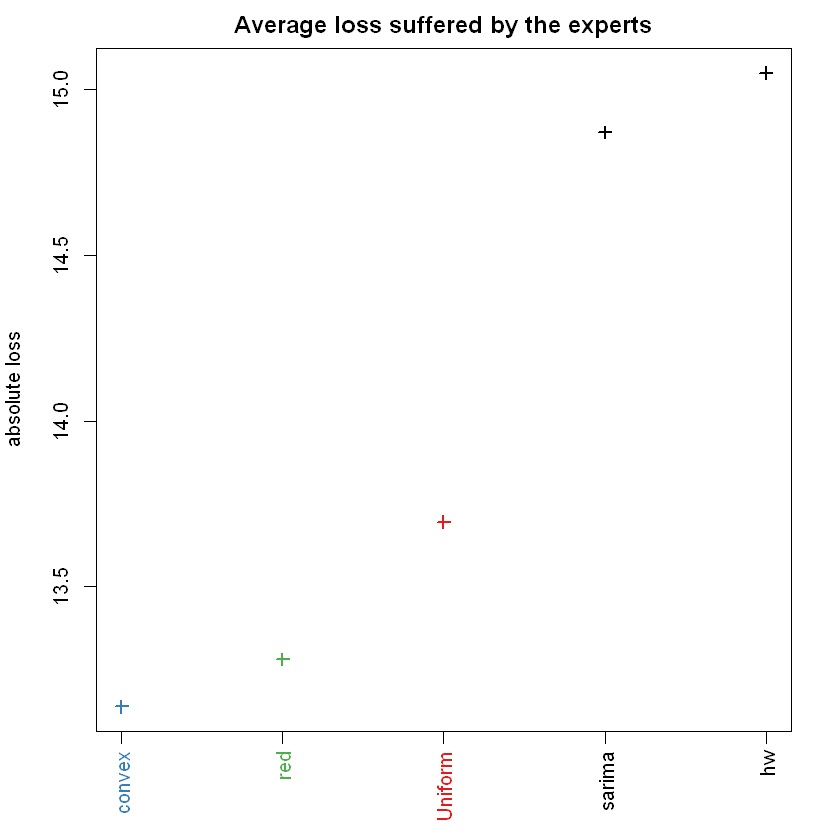

In [11]:
oracle.convex <- oracle(Y = acc.test, experts = X, loss.type = "absolute", model = "convex")
plot(oracle.convex)

In [12]:
print(oracle.convex)

Call:
oracle.default(Y = acc.test, experts = X, model = "convex", loss.type = "absolute")

Coefficients:
   red sarima       hw
 0.392  0.608 6.42e-21

                      rmse  mape
Best expert oracle:   14.8 0.102
Uniform combination:  16.2 0.109
Best convex oracle:   16.0 0.105


In [13]:
accuracy(as.vector(oracle.convex$prediction), acc.test) # 13.1...

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-7.209426,15.99292,13.13937,-7.138851,10.51354,-0.3411341,0.4136533


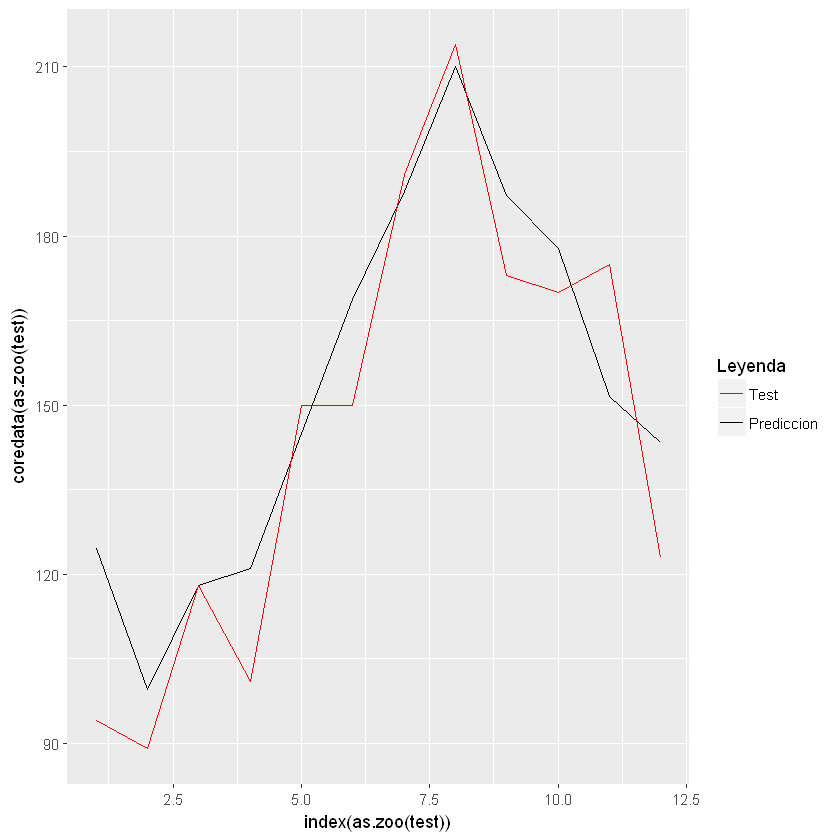

In [14]:
combine(as.vector(oracle.convex$prediction), acc.test)

Warning message in bestLinear(Y, experts, lambda = lambda, loss.type = loss.type):
"The best linear oracle is only approximated (using optim)."

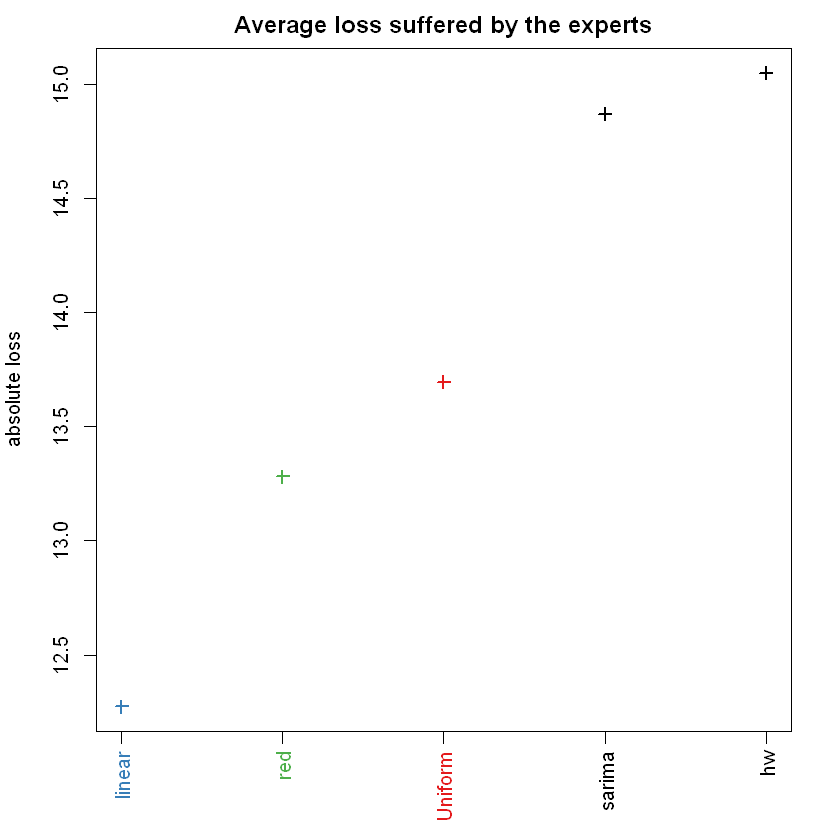

In [15]:
oracle.linear <- oracle(Y = acc.test, experts = X, loss.type = "absolute", model = "linear")
plot(oracle.linear)

In [16]:
print(oracle.linear)

Call:
oracle.default(Y = acc.test, experts = X, model = "linear", loss.type = "absolute")

Coefficients:
  red sarima     hw
 1.09 0.0113 -0.144

                      rmse   mape
Best expert oracle:   14.8 0.1020
Uniform combination:  16.2 0.1090
Best linear oracle:   14.4 0.0874


In [17]:
accuracy(as.vector(oracle.linear$prediction), acc.test) # 12.2...

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,1.854068,14.35385,12.27382,-0.3200637,8.738742,-0.3355286,0.4469252


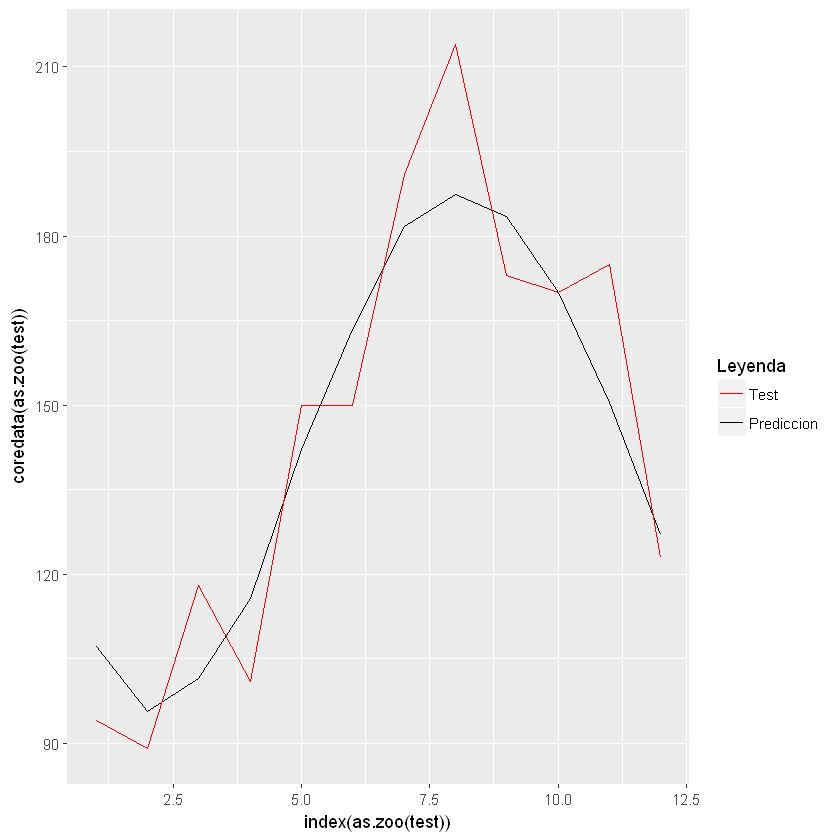

In [18]:
combine(as.vector(oracle.linear$prediction), acc.test)

#### Predicciones en línea

In [19]:
mix <- mixture(model = 'EWA', loss.type = 'absolute', coefficients = 'Uniform')
model <- mix

for (i in 1:length(as.vector(acc.test))) {
  model <- predict(model, X[i,], as.vector(acc.test)[i])
}
print(model)

Aggregation rule: EWA 
Loss function:  absolute loss 
Gradient trick:  TRUE 
Coefficients: 
 red   sarima       hw
   1 1.31e-05 4.22e-11


In [20]:
model$weights

red,sarima,hw
0.3333333,3.333333e-01,0.3333333
0.6054951,7.526204e-10,0.3945049
0.4559459,3.810984e-02,0.5059443
0.3249113,3.168107e-01,0.3582780
0.3325530,3.319768e-01,0.3354702
0.3333665,3.327078e-01,0.3339257
0.3333238,3.332839e-01,0.3333922
0.3333339,3.333243e-01,0.3333419
0.3333317,3.333336e-01,0.3333347
0.3333331,3.333335e-01,0.3333334


In [21]:
accuracy(as.vector(model$prediction), acc.test) # 14.08114

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,-8.660421,16.3776,14.08136,-7.812354,11.18899,-0.4796992,0.4517813


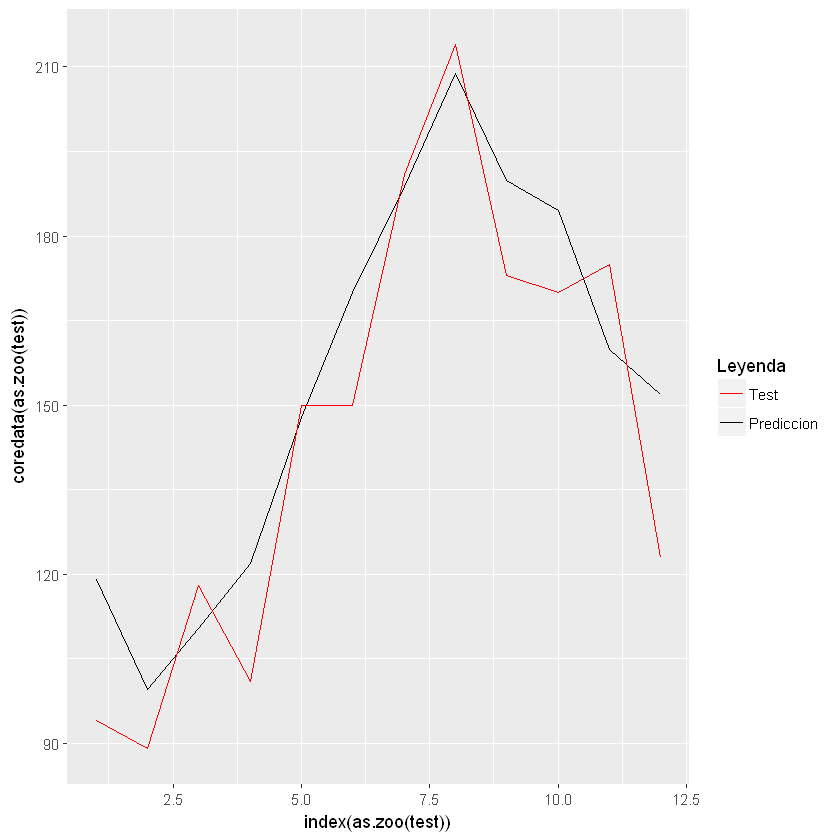

In [22]:
combine(as.vector(model$prediction), acc.test)

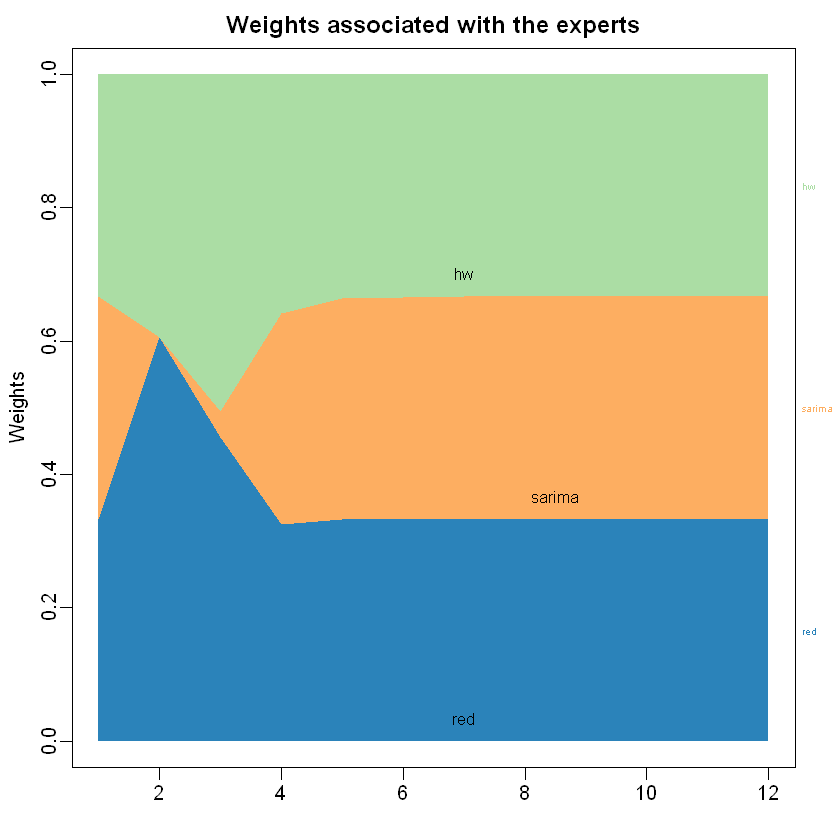

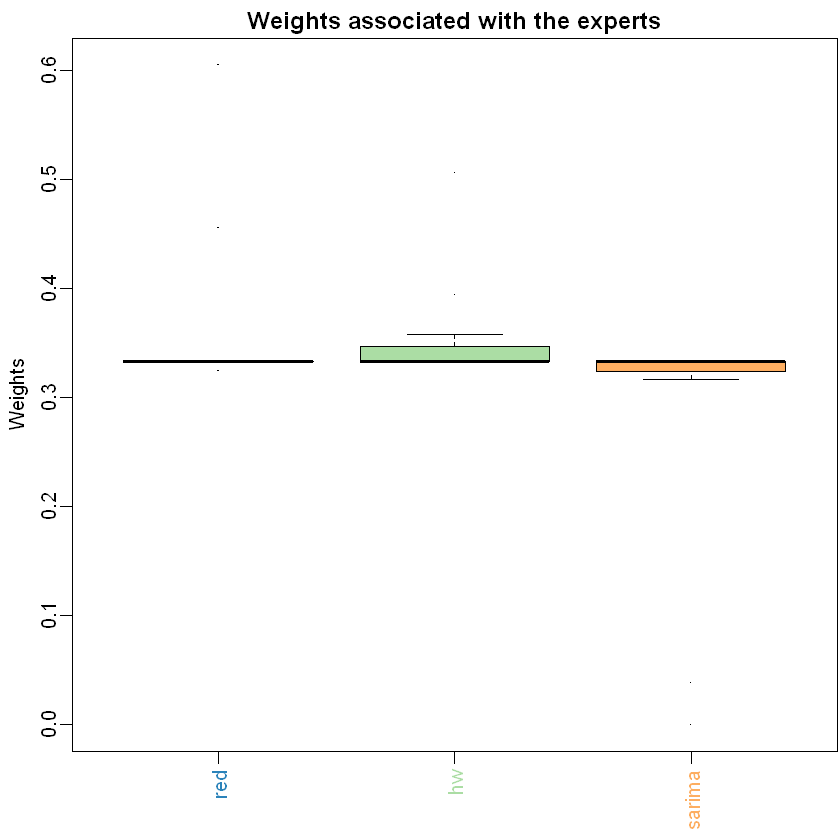

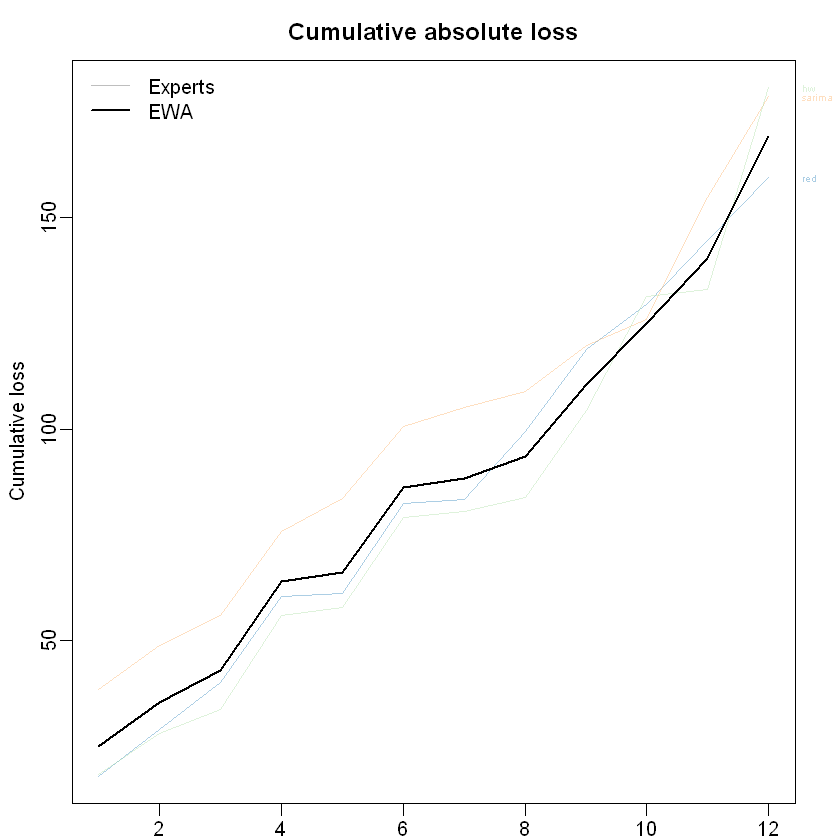

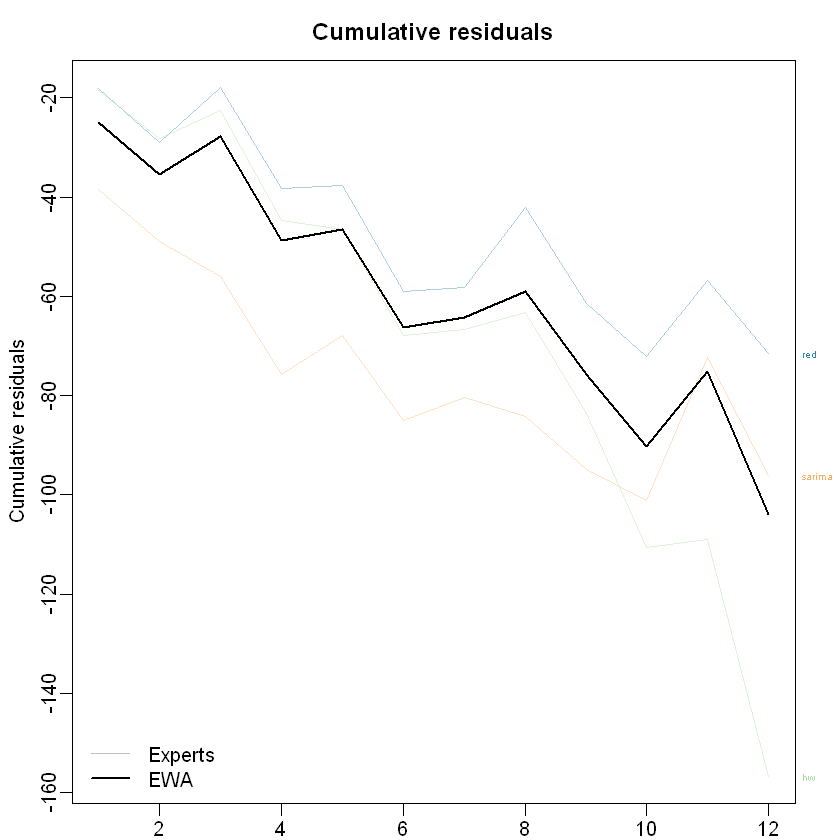

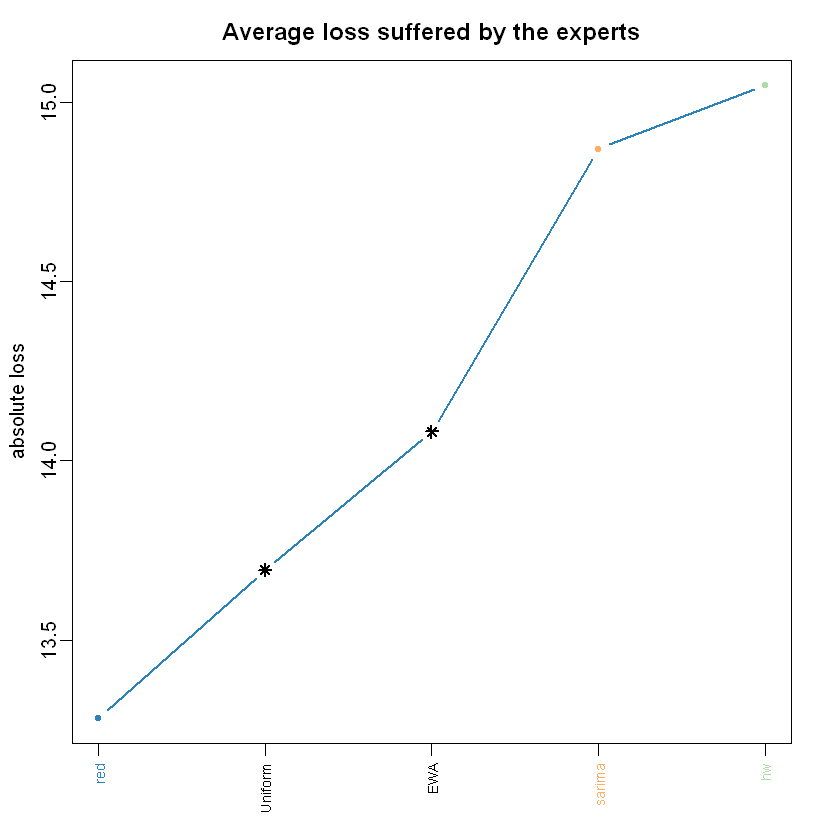

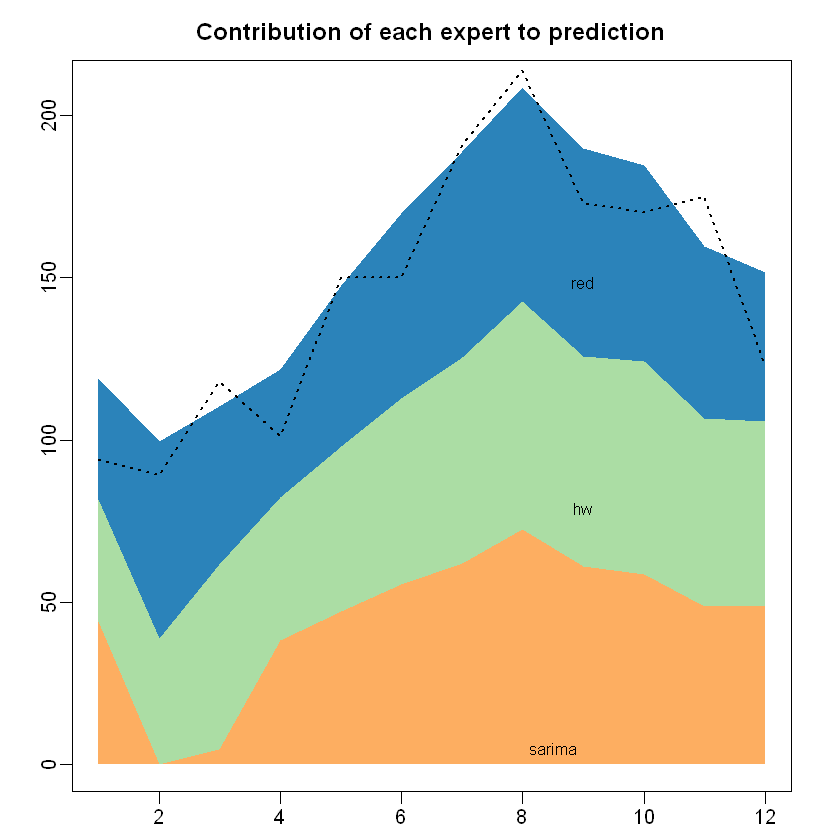

In [23]:
plot(model, pause = TRUE)